In [1]:
import numpy as np
import pandas as pd

In [2]:
stock_ids = ['TSLA', 'JPM', 'AAPL', 'AMGN', 'XOM']
stock_dfs = {}
for stock_id in stock_ids:
    stock_dfs[stock_id] = pd.read_csv(f'../data/processed/{stock_id}.csv')
    stock_dfs[stock_id]['ts_event'] = pd.to_datetime(stock_dfs[stock_id]['ts_event'])
    stock_dfs[stock_id]['stock_id'] = stock_id

In [3]:
# unified PCA across all stocks
stocks = pd.concat(list(stock_dfs.values()), axis=0)
ofis = stocks[[f'ofi_{i}' for i in range(5)]].to_numpy()

### Integrated OFI measure

Text(0, 0.5, 'Explained Variance')

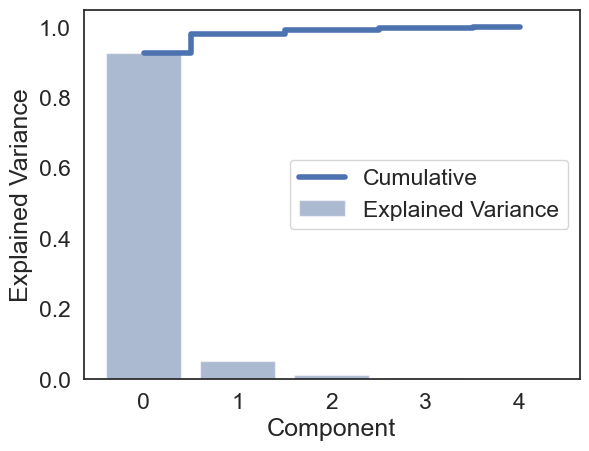

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=5)
pca.fit(ofis)
new_ofi = pca.transform(ofis)

sns.set_theme(style='white', font_scale=1.5)
explained_var = pca.explained_variance_ratio_
sns.barplot( explained_var, alpha=0.5, label='Explained Variance')
plt.step(np.arange(len(explained_var)), np.cumsum(explained_var),\
         drawstyle='steps-pre', lw=4, where = 'mid', label='Cumulative')
plt.legend(loc='center right')
plt.xlabel('Component')
plt.ylabel('Explained Variance')

In [5]:
print(explained_var)

[0.92786884 0.05300854 0.01163535 0.00465738 0.0028299 ]


<Axes: >

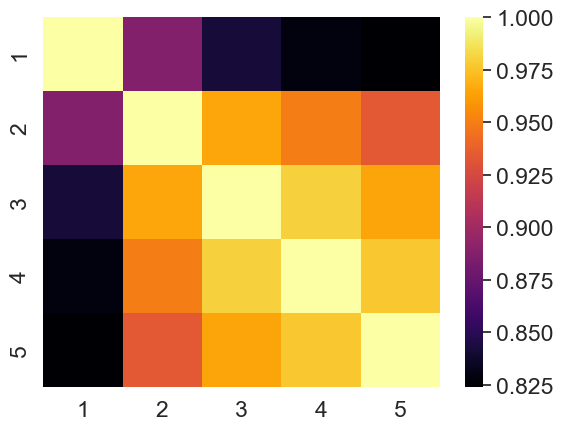

In [6]:
sns.heatmap(np.corrcoef(ofis, rowvar=False), cmap='inferno', fmt='.1f', xticklabels=list(range(1,6)), yticklabels=list(range(1,6)))#annot=True

In [7]:
weights = pca.components_[0] / np.sum(np.abs(pca.components_[0]))
stocks['integrated_ofi'] = ofis @ weights


#### Price Impact of Integrated OFI

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def run_single_impact_analysis(stocks, target_stock_id):
    '''
    Given dataframe of different stocks with timestamps and integrated ofi, fit linear regression model to predict contemporaneous log return from integrated OFI of that particular stock.
    Arguments:
        - stocks: DataFrame
        - target_stock_id: stock whose log_return is being predicted
    '''
    stock_df = stocks[stocks['stock_id'] == target_stock_id].copy()

    stock_df= stock_df.set_index('ts_event')
    stock_df = stock_df.between_time("10:00", "15:30")
    stock_df = stock_df.reset_index()

    stock_df = stock_df.dropna()
    X = stock_df['integrated_ofi'].to_numpy()[:, None]
    y = stock_df['log_return'].to_numpy()
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return y, y_pred

def run_cross_impact_analysis(stocks, target_stock_id):
    '''
    Given dataframe of different stocks with timestamps and integrated ofi, fit linear regression model to predict contemporaneous log return from integrated OFI of all present tsocks.
    Arguments:
        - stocks: DataFrame
        - target_stock_id: stock whose log_return is being predicted
    '''
    target_df = stocks[stocks['stock_id'] == target_stock_id]
    target_df= target_df.set_index('ts_event')
    target_df = target_df.between_time("10:00", "15:30")
    target_df = target_df.reset_index()
    target_df = target_df.rename({'integrated_ofi':f'integrated_ofi_{target_stock_id}'}, axis=1)
    for stock_id in stock_ids:
        if stock_id == target_stock_id:
            continue
        stock_df = stocks[stocks['stock_id'] == stock_id]

        # keep only data from 10:00-15:30
        stock_df= stock_df.set_index('ts_event')
        stock_df = stock_df.between_time("10:00", "15:30")
        stock_df = stock_df.reset_index()

        stock_df = stock_df[['ts_event', 'integrated_ofi']].rename({'integrated_ofi':f'integrated_ofi_{stock_id}'}, axis=1)
        target_df = target_df.merge(stock_df, on='ts_event', how='left')

    # replace missing minutes for other stocks with 0
    target_df = target_df.fillna(0)

    X = target_df[[f'integrated_ofi_{i}' for i in stock_ids]]
    print(X.shape)
    y = target_df['log_return']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    return y, y_pred

### Contemporaneous Single-Impact Analysis

In [9]:
r2_scores = []
for stock_id in stock_ids:
    y_true, y_pred = run_single_impact_analysis(stocks, stock_id)
    r2_scores.append(r2_score(y_true, y_pred))
single_impact_scores = pd.DataFrame({'Stock':stock_ids, 'Single Price Impact R2':r2_scores})

### Contemporaneous Cross-Impact Analysis

In [10]:
r2_scores = []
for stock_id in stock_ids:
    y_true, y_pred = run_cross_impact_analysis(stocks, stock_id)
    r2_scores.append(r2_score(y_true, y_pred))
cross_impact_scores = pd.DataFrame({'Stock':stock_ids, 'Cross Impact R2':r2_scores})

(662, 5)
(653, 5)
(662, 5)
(286, 5)
(650, 5)


In [15]:
pd.merge(single_impact_scores, cross_impact_scores, on='Stock').round(4)

,Stock,Single Price Impact R2,Cross Impact R2
0,TSLA,0.0253,0.0507
1,JPM,0.0051,0.0180
2,AAPL,0.0872,0.0911
3,AMGN,0.0011,0.0158
4,XOM,0.0075,0.0309
